Тестовое задание:

Возьмите свою страницу Вконтакте, соберите по ней таблицу с датой постов и количеством лайков и напишите SQL-запросы, которые позволят ответить на вопрос: что больше всего влияет на количество лайков: время суток публикации, день недели или промежуток между постами.
В качестве ответа приложите таблицу в формате CSV, SQL-запросы с необходимыми пояснениями и выводом. Вместо своей страницы можно взять станицу друга, в любом случае укажите адрес страницы.

Готовое тестовое задание вы можете отправить ссылкой на таблицу телеграм нашему HR-менеджеру -

Важно!
- обязательно представьтесь или приложите ссылку на резюме
- пишите в рабочее время 10.00-19.00
- вы можете взять комфортный срок на выполнение


**Получаем данные по постам**

In [ ]:
#библиотеки
!pip install vk_api
import vk_api
import sqlite3
from datetime import datetime
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
## Будем использовать API VK
## Нашим другом будет Павел Дуров

# Авторизация
vk_session = vk_api.VkApi(token='')
vk = vk_session.get_api()

# ID
# vk.com/durov
user_id = 'durov'

# Посты
posts = vk.wall.get(owner_id=user_id, count=100)

post_data = []
for post in posts['items']:


      data = datetime.fromtimestamp(post['date'])
      likes =  int(post['likes']['count'])# Количество лайков
      reposts = post['reposts']['count']# Количество репостов
      post_data.append({
          'data': data,
          'likes': likes,
          'reposts': reposts

                 }

              )
df = pd.DataFrame(post_data)
df.to_csv('vk_post.csv',encoding ='utf-8')

# Новый раздел

**Создание БД**

In [ ]:
# Добавлю в облако, что бы можно было загружать данные без скрипта постов.
# https://drive.google.com/file/d/1TUXYcbw5oAkRlCgP-viuYdMi0rtndmo6/view?usp=sharing

file_id = "1CObvE2kKiudSjA8wsHw41yb6eGCAUPY7"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url,index_col =0)
df

,data,likes,reposts
0,2018-05-08 18:59:24,238195,14317
1,2018-05-03 13:05:53,25867,5639
2,2018-05-01 15:19:57,108137,5137
3,2018-05-01 10:01:25,47796,1109
4,2018-04-30 17:03:43,28271,1460
...,...,...,...
95,2015-08-03 18:35:42,31139,2491
96,2015-07-21 23:33:34,109440,2687
97,2015-07-20 12:26:37,26317,379
98,2015-07-20 12:21:13,9938,145


In [ ]:
#создание бд и заливка
con = sqlite3.connect('db')
df.to_sql('vk_post',con,index=False,if_exists='replace')



100

In [ ]:
sql = ''' SELECT *
FROM vk_post '''

In [ ]:

def select(sql):
  return pd.read_sql(sql,con)

In [ ]:
select(sql)

,data,likes,reposts
0,2018-05-08 18:59:24,238195,14317
1,2018-05-03 13:05:53,25867,5639
2,2018-05-01 15:19:57,108137,5137
3,2018-05-01 10:01:25,47796,1109
4,2018-04-30 17:03:43,28271,1460
...,...,...,...
95,2015-08-03 18:35:42,31139,2491
96,2015-07-21 23:33:34,109440,2687
97,2015-07-20 12:26:37,26317,379
98,2015-07-20 12:21:13,9938,145


**Сводные таблицы**

In [ ]:
# Вычислим поля и построим сводные таблицы:
#день недели


sql = '''
SELECT
CASE strftime('%w', data)
WHEN '0' THEN 'Воскресенье'
WHEN '1' THEN 'Понедельник'
WHEN '2' THEN 'Вторник'
WHEN '3' THEN 'Среда'
WHEN '4' THEN 'Четверг'
WHEN '5' THEN 'Пятница'
WHEN '6' THEN 'Суббота'
END AS day_of_week,
COUNT(*) AS publication_count,
AVG(likes) AS avg_likes
FROM vk_post
GROUP BY day_of_week
ORDER BY publication_count DESC; '''

In [ ]:
select(sql)

,day_of_week,publication_count,avg_likes
0,Понедельник,24,62885.625000
1,Вторник,21,56650.000000
2,Четверг,18,25527.166667
3,Воскресенье,15,41959.400000
4,Пятница,9,35392.222222
5,Среда,7,34564.285714
6,Суббота,6,30699.333333


In [ ]:
#время суток публикации

sql = ''' SELECT
CASE
WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 0 AND 5 THEN 'Ночь'
WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 6 AND 11 THEN 'Утро'
WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 12 AND 17 THEN 'День'
WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 18 AND 23 THEN 'Вечер'
END AS time_of_day,
COUNT(*) AS publication_count,
ROUND(AVG(likes), 2) AS avg_likes
FROM vk_post
GROUP BY time_of_day
ORDER BY publication_count DESC;'''


In [ ]:
select(sql)

,time_of_day,publication_count,avg_likes
0,День,43,47805.77
1,Вечер,35,45337.71
2,Утро,17,45058.65
3,Ночь,5,24799.20


In [ ]:
#промежуток между постами

sql = '''
WITH ordered_posts AS (
    SELECT
        data,
        LAG(data) OVER (ORDER BY data DESC) AS prev_post_time
    FROM vk_post
)
SELECT
    data AS current_post_time,
    prev_post_time,
    ROUND((JULIANDAY(data) - JULIANDAY(prev_post_time)) * 1440) AS minutes_since_previous_post
FROM ordered_posts
ORDER BY current_post_time DESC ; '''

In [ ]:
select(sql)

,current_post_time,prev_post_time,minutes_since_previous_post
0,2018-05-08 18:59:24,None,NaN
1,2018-05-03 13:05:53,2018-05-08 18:59:24,-7554.0
2,2018-05-01 15:19:57,2018-05-03 13:05:53,-2746.0
3,2018-05-01 10:01:25,2018-05-01 15:19:57,-319.0
4,2018-04-30 17:03:43,2018-05-01 10:01:25,-1018.0
...,...,...,...
95,2015-08-03 18:35:42,2015-08-04 11:21:17,-1006.0
96,2015-07-21 23:33:34,2015-08-03 18:35:42,-18422.0
97,2015-07-20 12:26:37,2015-07-21 23:33:34,-2107.0
98,2015-07-20 12:21:13,2015-07-20 12:26:37,-5.0


In [ ]:
sql = '''
WITH ordered_posts AS (
    SELECT
        data,
        LAG(data) OVER (ORDER BY data) AS prev_post_time  -- Сортируем по возрастанию!
    FROM vk_post
)
SELECT
    data AS current_post_time,
    prev_post_time,
    ROUND((JULIANDAY(data) - JULIANDAY(prev_post_time)) * 1440) AS minutes_since_previous_post
FROM ordered_posts
ORDER BY current_post_time DESC; '''

In [ ]:
select(sql)

,current_post_time,prev_post_time,minutes_since_previous_post
0,2018-05-08 18:59:24,2018-05-03 13:05:53,7554.0
1,2018-05-03 13:05:53,2018-05-01 15:19:57,2746.0
2,2018-05-01 15:19:57,2018-05-01 10:01:25,319.0
3,2018-05-01 10:01:25,2018-04-30 17:03:43,1018.0
4,2018-04-30 17:03:43,2018-04-30 12:12:04,292.0
...,...,...,...
95,2015-08-03 18:35:42,2015-07-21 23:33:34,18422.0
96,2015-07-21 23:33:34,2015-07-20 12:26:37,2107.0
97,2015-07-20 12:26:37,2015-07-20 12:21:13,5.0
98,2015-07-20 12:21:13,2015-07-19 21:11:49,909.0


Выводы:

Сводные таблицы показали, что стоит обратить внимание на то, что в понедельник среднее количество лайков больше, чем в другие дни, а также что днем среднее количество лайков больше, чем в другое время суток. Но для того, чтобы подтвердить предположение, нужно провести статистические тесты.

**Статистические тесты**

У нас два типа предикторов:
    
    Категориальные переменные — день недели и время суток;
    Количественная переменная — промежуток времени между постами.

Для сравнения групп по категориальным признакам используем тест Краскела-Уоллиса, так как он подходит для трёх и более групп и не требует нормальности распределения.
Для анализа связи между интервалом между постами и количеством лайков используем корреляцию Спирмена, поскольку она оценивает монотонную (не обязательно линейную) связь и устойчива к выбросам.

Наши гипотезы выглядят так:
    
    H0 Нулевая гипотеза что среднее по дням и суткам не отличается, нет разницы,различия случайны.

    H1 Альтернативная гипотиза, что что разница есть и время суток и день недели влияет на среднее количество лайков.


In [ ]:
df = pd.read_sql("""
    WITH post_intervals AS (
        SELECT
            *,
            LAG(data) OVER (ORDER BY data) AS prev_post_time,
            (JULIANDAY(data) - JULIANDAY(LAG(data) OVER (ORDER BY data))) * 24 AS hours_since_prev_post
        FROM vk_post
    )
    SELECT
        likes AS like_count,
        data AS post_time,
        CASE strftime('%w', data)
            WHEN '0' THEN 'Воскресенье'
            WHEN '1' THEN 'Понедельник'
            WHEN '2' THEN 'Вторник'
            WHEN '3' THEN 'Среда'
            WHEN '4' THEN 'Четверг'
            WHEN '5' THEN 'Пятница'
            WHEN '6' THEN 'Суббота'
        END AS day_of_week,
        CASE
            WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 0 AND 5 THEN 'Ночь'
            WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 6 AND 11 THEN 'Утро'
            WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 12 AND 17 THEN 'День'
            WHEN CAST(strftime('%H', data) AS INTEGER) BETWEEN 18 AND 23 THEN 'Вечер'
        END AS time_of_day,
        hours_since_prev_post
    FROM post_intervals
    WHERE prev_post_time IS NOT NULL
    ORDER BY data;
""", con=con)

# 1. Проверка влияния времени суток (Краскел-Уоллис)
time_groups = [group['like_count'].values for name, group in df.groupby('time_of_day') if len(group) > 0]
if len(time_groups) >= 2:
    stat, p = stats.kruskal(*time_groups)
    print(f"Влияние времени суток: p-value = {p:.4f}")
else:
    print("Количество групп <2. Тест не подходит.")

# 2. Проверка влияния дня недели (Краскел-Уоллис)
day_groups = [group['like_count'].values for name, group in df.groupby('day_of_week') if len(group) > 0]
if len(day_groups) >= 2:
    stat, p = stats.kruskal(*day_groups)
    print(f"Влияние дня недели: p-value = {p:.4f}")
else:
    print("Количество групп <2. Тест не подходит")

# 3. Корреляция интервала и лайков (Спирмен)
if len(df) >= 2:
    corr, p = stats.spearmanr(df['hours_since_prev_post'], df['like_count'])
    print(f"Корреляция интервала и лайков: r = {corr:.3f}, p = {p:.4f}")
else:
    print("Ошибка в df")

Влияние времени суток: p-value = 0.7880
Влияние дня недели: p-value = 0.2596
Корреляция интервала и лайков: r = -0.142, p = 0.1616


Во всех случаях p-value > 0.05, следовательно, мы не отклоняем нулевую гипотезу.
Это означает, что на уровне значимости 5% не обнаружено статистически значимой связи между:

    днём недели и количеством лайков,
    временем суток и количеством лайков,
    интервалом между публикациями и количеством лайков.

Однако это не означает, что связи нет — возможно, она слабая, маленькая выборка.

**Графики.Боксы**

Посмотрим на графики боксплотов

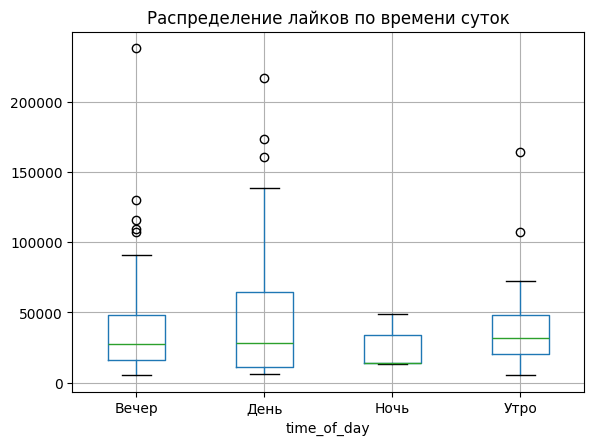

In [ ]:
# По времени суток.
df.boxplot(column='like_count', by='time_of_day')
plt.title('Распределение лайков по времени суток')
plt.suptitle('')
plt.show()

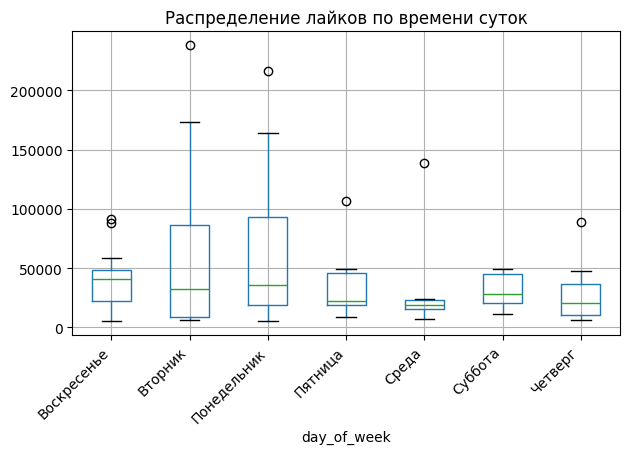

In [ ]:
# По дням недели.
df.boxplot(column='like_count', by='day_of_week')
plt.xticks(rotation=45, ha='right')
plt.title('Распределение лайков по времени суток')
plt.suptitle('')
plt.tight_layout()
plt.show()

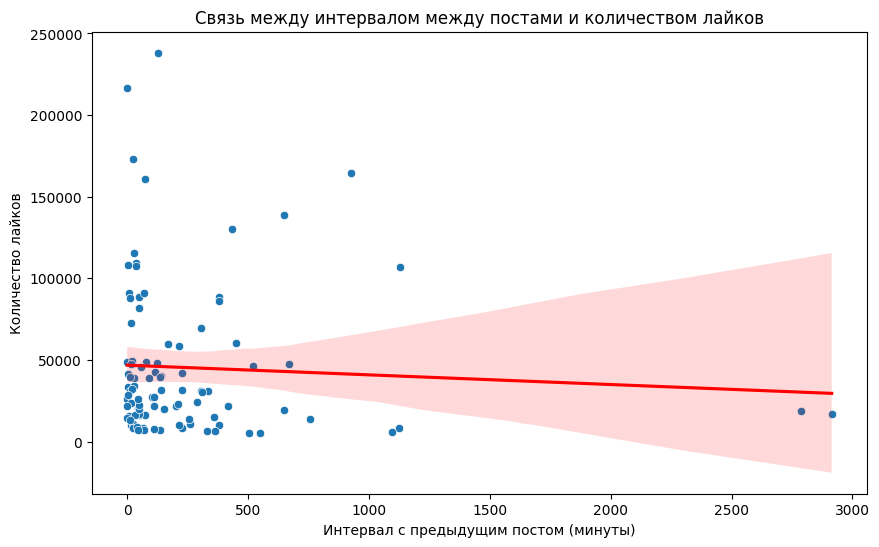

In [ ]:
# Интервал между постами.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='hours_since_prev_post', y='like_count')
sns.regplot(data=df, x='hours_since_prev_post', y='like_count', scatter=False, color='red')
plt.title('Связь между интервалом между постами и количеством лайков')
plt.xlabel('Интервал с предыдущим постом (минуты)')
plt.ylabel('Количество лайков')
plt.show()

Выводы:

    На графиках отчетливо видно выбросы. Например днем верхний ус ящика тянется вверх,а также в понедельник и вторник. Возможно, это и есть причина нашего предположения после создания сводных таблицы, что существуют закономерности.

    Интервал между постами, облако без четкой линии - слабая связь R2 -0.14. И отрицательная корреляция  чем больше интервал,тем меньше лайков.

**Повторные тесты с устранением выбросов**

Для того,что бы более убедительно узнать, что стат.значимой зависимосте между днем недели,времнем суток,промежутков между постов и лайками мы удалим выбросы и проведем тесты еще раз.





In [ ]:
# Вычисляем IQR для like_count
Q1 = df['like_count'].quantile(0.25)
Q3 = df['like_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Границы выбросов: ниже {lower_bound:.0f} или выше {upper_bound:.0f}")
print(f"Количество выбросов: {(df['like_count'] > upper_bound).sum()}")

# Фильтруем выбросы (оставляем только "нормальные" значения)
df_no_outliers = df[
(df['like_count'] >= lower_bound) &
(df['like_count'] <= upper_bound)
].copy()

print(f"Размер до: {len(df)}, после удаления выбросов: {len(df_no_outliers)}")

Границы выбросов: ниже -35714 или выше 100002
Количество выбросов: 12
Размер до: 99, после удаления выбросов: 87


In [ ]:
### Проводим новые тесты без выбросов.

# 1. Проверка влияния времени суток (Краскел-Уоллис)
time_groups = [group['like_count'].values for name, group in df_no_outliers.groupby('time_of_day') if len(group) > 0]
if len(time_groups) >= 2: я
    stat, p = stats.kruskal(*time_groups)
    print(f"Влияние времени суток: p-value = {p:.4f}")
else:
    print("Количество групп <2. Тест не подходи")

# 2. Проверка влияния дня недели (Краскел-Уоллис)
day_groups = [group['like_count'].values for name, group in df_no_outliers.groupby('day_of_week') if len(group) > 0]
if len(day_groups) >= 2:
    stat, p = stats.kruskal(*day_groups)
    print(f"Влияние дня недели: p-value = {p:.4f}")
else:
    print("Количество групп <2. Тест не подходи")

# 3. Корреляция интервала и лайков (Спирмен)
if len(df) >= 2:
    corr, p = stats.spearmanr(df_no_outliers['hours_since_prev_post'], df_no_outliers['like_count'])
    print(f"Корреляция интервала и лайков: r = {corr:.3f}, p = {p:.4f}")
else:
    print("Ошибка в df")

Влияние времени суток: p-value = 0.8057
Влияние дня недели: p-value = 0.2794
Корреляция интервала и лайков: r = -0.181, p = 0.0933


По результатам повторных стат.тестов имеем :

    Время суток. p value вырос с 0,788 до 0,806. Удаление выбросов не выявило связь. Наоборот,различия стали менее выражены.

    Дни недели. p value  вырос с 0,260 до 0,279. Удаление выбрасов не выявило связь. Наборот,различия также стали менее выражены.

    Интервал между постами. p value  уменьшился с 0,1616 до 0,0933, корреляция выросла с - 0,142 до - 0,181. Это на мой взгляд, интересное изминение. p value  стал находиться очень близко к  0,05. И за этой взаимосвязью стоит наблюдать.

**Выводы**


На основе проведенного анализа можем сделать выводы:
    
    Сводные таблицы на основе средних лайков, могут дать неверную интерпритацию выводов.
  
    Ни один из факторов - время суток,день недели, интервал между постами не показал статического значимого влияния на количество лайков. p value >0.05

    После удаления выбросов связь между интервалом и лайками стала чуть сильнее и близко находиться к значимости. За данным фактором стоит наблюдать.


В качестве дальнешего исследования, я бы увеличил выборку и попробовал логарифмировать переменную лайки.